# XY-calibration (F3)

In [1]:
cd ..

/Users/Vincent/Github/FireBallPipe



| #  | Name                               | Done                     |       Comment               |
|----|------------------------------------|--------------------------|-----------------------------|
| 1  | Have a mask-detector mapping       | <input type="checkbox">  |  And send region file to zeren |
| 2  | Use the previous XY mapping        | <input type="checkbox">  | of the same mask, if never done do a new one   |
| 2.a  |Add mask rotation for F2       | <input type="checkbox">  |                             |
| 3  | Reset magnification/offset/angle   | <input type="checkbox">  |                             |
| 4  | Be sure of the slits path          | <input type="checkbox">  |  Use only regular slits, big moves, do not use slits that are seen with one line or in shadow   |
| 4.a  | Decide to use or not hysteresis compensation          | <input type="checkbox">  |  Adds ~1h in total + slight code complexity but might improve results by <1''  |
| 5  | Account from Zeren offset          | <input type="checkbox">  |                             |
| 6  | Add slits path in google drive     | <input type="checkbox">  |                             |
| 7  | Add CNES moves to google drive     | <input type="checkbox">  |                             |


In [2]:
# %matplotlib widget
%load_ext autoreload
%autoreload 2

import sys
import numpy as np
from astropy.io import fits
from astropy import wcs, coordinates
from astropy import units as u
from astropy.wcs.utils import proj_plane_pixel_scales
from matplotlib import pyplot as plt
from astropy.table import Table, vstack 
import matplotlib.patches as patches
import unittest
from mpl_interactions import heatmap_slicer
import pandas as pd
import datetime 
# os.chdir(os.path.dirname(os.path.realpath(__file__)))
sys.path.insert(1, './Calibration')
from guider2UV.guider2UV import Guider2UV, diff_skycoord, fit_model, plot_fit
from guider2UV.MaskAstrometry import LocalScienceMaskProjector
from Calibration.mapping import Mapping

# encoder gains 2022:
CEg = 1.0187 # CEg = 1.02928 # 2018
Elg = 1.0090 # Elg = 1.00379 # 2018
print("After calibration of the encoders, El is %0.5f ''/inc and Ce is %0.5f ''/inc" %(Elg*0.092,CEg*0.01))


After calibration of the encoders, El is 0.09283 ''/inc and Ce is 0.01019 ''/inc


## initialization from last xy calib
---------------------------------
This was actually a mistake, it should slways be done from the same mask (same field center), or create a new G2UV object

In [3]:
# prerequisites:
Field = "F3"
previous_xy_mapping = "Calibration/Mappings/2018/XY/Guider2UV_F3_nogamma.new.pkl"
mask_det_map_file = "Calibration/Mappings/2022/mask_to_det_mapping/mapping-mask-det-w-2022-5-F3_60.pkl"
target_filename = 'Calibration/Targets/2022/targets_%s.csv'%(Field)
Hysteresis_compensation = False
if input("Are you sure that you want to use Hysteresis_compensation = %s? (y/n)"%(Hysteresis_compensation))!="y":
    raise ValueError("Please be verify the value of Hysteresis_compensation")


In [4]:
# load model from previous XY calib 
G2UV = Guider2UV(filename=previous_xy_mapping)

# eventually reset the guider-scmask rotation to 0 and magnification correction to 0.
G2UV.mask_rotation = 0.0*u.arcmin
G2UV.FieldP.gamma = 1. 
G2UV.FieldP.radial_mag_polynomial = (42.26134, 0., 0.)
G2UV.FieldP.radial_mag_inv_polynomial = (1./42.26134, 0., 0.)
print(G2UV)

# if you already know the approx angular distance between guidercenter and FOVcenter, set it:
#G2UV.FOV_center_guider_coord = coordinates.SkyCoord(delta_x*u.deg, # x guider axis (x axis in guider local frame, see XYcalib figure)
#                                                    delta_y*u.deg, # y guider axis (y axis guider local frame, see XYcalib figure)
#                                                    frame = G2UV.GuiderP.localframe)

# load targets
F1 = Table.read(target_filename, format='ascii')

# load mask-UVdetector mappings
mask_det_map = Mapping(mask_det_map_file)

if input("Are you sure that these values make sense for %s: Theta=%s, center=%s? (y/n)"%(Field, G2UV.FieldP.rotation, G2UV.FieldP.center))!="y":
    raise ValueError("Please verify the initialization mapping")



FOV center angular position in guider <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.42402654, 36.43499699)>): (lon, lat) in deg
    (0.18212015, -0.00658703)>
FOV center pixel position in guider [array(1356.48459465), array(515.54397687)]

Guider2UV object:
    Local Field Projector: 
ScienceMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=-90.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (352.3424, 0.21245)>)>
    gamma: 1.0

    Guider Field Projector: 
GuiderMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.42402654, 36.43499699)>)>
    wcs: WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 250.424026537  36.4349969891  
CRPIX : 640.0  540.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.00024648264068189  0.00024664057706659  
NAXIS : 0  0

    mask_rotation: 0.0 arcmin
    FOV 

## Alternative initialisation for new fields:
---------------------------------------

In [5]:

# f_ra, f_dec, f_rot = 0, 0, 0
# Field_center=coordinates.SkyCoord(f_ra * u.deg, f_dec * u.deg)
# # get FOVcenter & guider wcs from another field
# #  put pkl from a functionning mapping from another field
# G2UVother = Guider2UV(filename=previous_xy_mapping)
# FOVcenter = G2UVother.FOV_center_guider_coord
# guider_wcs = G2UVother.GuiderP.w
# G2UV = Guider2UV(Field_center=Field_center,
#                  Field_rotation= f_rot * u.deg,
#                  Field_gamma=1.0,  # platescale correction (need to update the polynomial in the MaskAstrometry.py)
#                  FOVcenter_guider_coord=FOVcenter,
#                  guider_wcs = guider_wcs,
#                  )
                 
# FNEW = Table.read(target_filename, format='ascii')
# mask_det_map = Mapping(mask_det_map_file)

# print(G2UV)

## 1-  Rotate mask carousel
## 2- Diffuse UV image

Copy the offset from [this spreadsheet step "Compute offsets with previous diffuse illumination image"](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

In [6]:
# This offset in X and Y should be positive if the slit position in tghe new image appears to be shifted towards the top right
diffuse_offset = np.array([0.88,-3.00])
G2UV.set_detector_mapping(mask_det_map, offsets = diffuse_offset+1) #+1 offset is to account for DS9 vs python offset
direct_map = lambda w, x, y: mask_det_map.map(w, x, y) + diffuse_offset
inv_map = lambda w, x, y: mask_det_map.inv_map(w, x - diffuse_offset[0], y - diffuse_offset[1])

## 3 - Set guider at best focus          
## 4 - Align siderostat frames           
## 5 - Go to guider reference            
## 6 - Set UV/guider best focus offset   
## 7 - Rotate mask carousel              
## 8 - Through focus in UV               
## 9 - Note open-mask guider ref point   
    

## 10 - Go through the list of slits      

['23', '36', '2', '13', '32', '11',"4"]

Here we struggled to find the good path because of faint 202/206 lines and of shadow of fiber holder

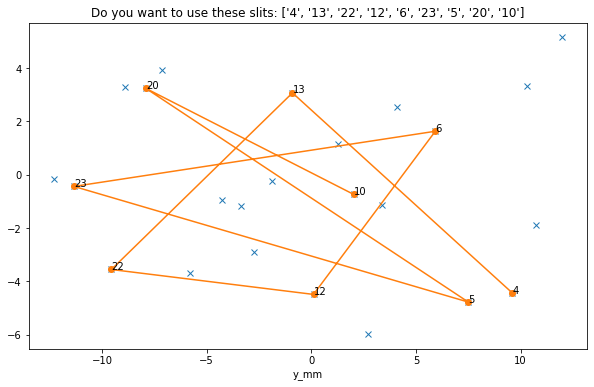

Internal-count,x_mm,y_mm,RA,DEC,ra_diff,dec_diff,angular_distance
str2,float64,float64,float64,float64,float64,float64,float64
4,9.606448141617294,-4.438478203336938,352.5700988769531,0.10724475234746933,896.4828045669061,-640.5059605836868,1101.784599832189
13,-0.9010535220373401,3.0724750743209586,352.3210754394531,0.2851630747318268,738.1622441627849,565.1210010051727,929.6479142581493
22,-9.551649625200541,-3.555461620393433,352.11602783203125,0.12818501889705658,-823.8333429206866,79.2756680294037,827.6388152143312
12,0.10439565884226028,-4.4904126516402565,352.344871,0.106164,-496.06120469011836,-521.7387143417359,719.922221383379
6,5.92437193981131,1.632129696087109,352.482666015625,0.2510914206504822,1472.9727117804312,176.50951434173587,1483.5107745826967
23,-11.341588243654323,-0.43809484447039143,352.073503,0.202061,-1607.8889668212646,370.1523632904052,1649.9453632393486
5,7.5025532792065714,-4.778575854140258,352.5201416015625,0.09924089908599854,1313.7431465028847,-683.7893843650818,1481.0432057011967
20,-7.9019272609735784,3.2392711320202587,352.15521240234375,0.2891823947429657,-846.1562145493774,338.9959752559662,911.5364011712728
10,2.0224236704981835,-0.7366939649626044,352.3902587890625,0.19501684606075287,0.0,0.0,0.0


In [7]:
# can not do 24 and 2 because they are not well mapped!

slits =['4', '23', '9', '6', '22', '5',"11"] # with only 213
slits =['4', '13', '22', '12', '6', '23',"5","20","10"] # with 206


F1['Internal-count'] = F1['Internal-count'].astype(str)
F1p = F1.to_pandas()
from functools import reduce
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# selected_slits = F1[mask.values]['Internal-count',"x_mm","y_mm","ra","dec"]
# selected_slits['Internal-count'] = selected_slits['Internal-count'].astype(str)
selected_slits = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1p[F1p['Internal-count'] == i],slits))))
ra,dec = "RA", "DEC"
x,y = "x_mm","y_mm"
plt.figure(figsize=(10,6))
plt.plot(F1[x],F1[y],"x")
plt.plot(selected_slits[x],selected_slits[y],"-o")
for s in selected_slits:
    plt.text(s[x],s[y],s["Internal-count"])
plt.xlabel("x_mm")
plt.xlabel("y_mm")
plt.title("Do you want to use these slits: %s"%(slits))
plt.show()

selected_slits = selected_slits['Internal-count',x,y,ra,dec]
slit_path = selected_slits#Table.from_pandas(selected_slits)   # vstack((selected_slits,selected_slits[::-1]) )
slit_path["ra_diff"] = list((slit_path[ra][:-1] - slit_path[ra][1:])*np.cos(slit_path[dec][:-1]*np.pi/180)) + [0]
slit_path["dec_diff"] = list((slit_path[dec][:-1] - slit_path[dec][1:])) + [0]

slit_path["ra_diff"] *= 3600
slit_path["dec_diff"] *= 3600
slit_path["angular_distance"] = np.sqrt(slit_path["ra_diff"]** 2 + slit_path["dec_diff"]** 2)
try:
    slit_path.to_pandas().to_clipboard()
except Exception:
    pass
slit_path

The slits table has been copied. Add it to the [slit tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

In [8]:
moves, flags, slit_coords = G2UV.compute_autocoll_moves_slits(slits, F1, hystcomp = Hysteresis_compensation)
moves = pd.DataFrame(np.hstack((moves,flags[:,None])), columns=["EL","CE","UV_image"])#,dtype=[("EL",float),("CE",float),("UV_image",float)])
# assert moves.sum(axis=0)[0] <0.1
# assert moves.sum(axis=0)[1] <0.1
moves["UV_image"] = moves["UV_image"].astype(bool)
moves["EL_abs"] =  [np.sum(moves["EL"][:i+1]) for i in range(len(moves))]
moves["CE_abs"] = [np.sum(moves["CE"][:i+1]) for i in range(len(moves))]

# slit_path['lon'] = [s.lon.deg*3600 for s in slits_coord]
# slit_path['lat'] =  [s.lat.deg*3600 for s in slits_coord]
# slit_path
print("(They have been copied to clipboard, paste it in the spreadsheet)")
moves.to_clipboard()

if ~Hysteresis_compensation:
    print("Carefull, with Hysteresis_compensation==%s the last move to return to the guider is not given. You just need to do -∑all moves"%(Hysteresis_compensation))
    print("You should then add EL=%0.4f and CE=%0.4f"%(moves.sum(axis=0)[0],moves.sum(axis=0)[1]))

moves 


slit position in mm on mask: [ 9.60644814 -4.4384782 ]
slit position in mm on mask: [-0.90105352  3.07247507]
slit position in mm on mask: [-9.55164963 -3.55546162]
slit position in mm on mask: [ 0.10439566 -4.49041265]
slit position in mm on mask: [5.92437194 1.6321297 ]
slit position in mm on mask: [-11.34158824  -0.43809484]
slit position in mm on mask: [ 7.50255328 -4.77857585]
slit position in mm on mask: [-7.90192726  3.23927113]
slit position in mm on mask: [ 2.02242367 -0.73669396]

targets local coords in siderostat local frame:
EL: 138.2 arcsec ; CE: 409.0 arcsec
EL: 456.9 arcsec ; CE: -25.8 arcsec
EL: 175.7 arcsec ; CE: -383.7 arcsec
EL: 136.0 arcsec ; CE: 15.8 arcsec
EL: 395.8 arcsec ; CE: 256.7 arcsec
EL: 308.0 arcsec ; CE: -457.8 arcsec
EL: 123.8 arcsec ; CE: 322.0 arcsec
EL: 464.0 arcsec ; CE: -315.5 arcsec
EL: 295.3 arcsec ; CE: 95.2 arcsec

siderostat moves sequence: 
(They have been copied to clipboard, paste it in the spreadsheet)
Carefull, with Hysteresis_compensati

,EL,CE,UV_image,EL_abs,CE_abs
0,138.248116,409.038970,True,138.248116,409.038970
1,318.699541,-434.805646,True,456.947657,-25.766676
2,-281.231996,-357.965970,True,175.715661,-383.732647
3,-39.671191,399.571958,True,136.044470,15.839311
4,259.787455,240.833514,True,395.831924,256.672825
5,-87.842326,-714.474022,True,307.989598,-457.801197
6,-184.172268,779.779951,True,123.817329,321.978754
7,340.207702,-637.445069,True,464.025031,-315.466315
8,-168.705383,410.674579,True,295.319648,95.208264


The moves has been copied. Add it to the [moves tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

Copy below the observed slits position from the [slit tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

In [9]:
slits_coord_obs_det = np.array([
[ 1346.5,	435.5  ],
[ 1842.4207,1214.4992  ],
[ 1414.5  ,	1875.5  ],
# [ ? ,   	?  ],
[ 1747.5 ,	707.5  ],
[ 1619.5 ,	2000.5  ],
[ 1321.5 ,	593.5  ],
[ 1862.1 ,	1746.9  ],
[ 1589.5,	1002.5  ]]) 


In [10]:
valid = np.isfinite(slits_coord_obs_det[:,0])
obs_wave = 0.20619
print("wave: ", obs_wave)
# slits_coord_valid = [slit_coords[i] for i in np.nonzero(valid)[0]]
# slits_valid = slits[valid]
slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
slits_coord_obs

if input("Are you sure you computed the barycenter on the line %s? Remember that it's better to use 206 line to probe a bigger part of the detector. It might require gain and longer exposure though. Be sure to always compute the centroid on the same line. (y/n)"%(obs_wave))!="y":
    raise ValueError("Please change obs_wave parameter (c)")


wave:  0.20619


### look at siderostat frame hysteresis 

In [11]:
if Hysteresis_compensation:
    mid  = len(slits_coord_obs_det)//2
    pair_diff = slits_coord_obs_det[:mid] - slits_coord_obs_det[::-1][:mid]
    moves_sign  = np.sign(moves[2:mid+2])
    pair_diff_signed = pair_diff * moves_sign
    valid = np.arange(len(moves_sign))#[0,2,3,4]
    fig, (ax0,ax1) = plt.subplots(1,2)
    ax0.plot(pair_diff_signed[valid,0],'*-')
    ax0.set_title("El pair diff")
    ax0.set_ylabel("El arcsec")
    ax1.plot(pair_diff_signed[valid,1],'*-')
    ax1.set_title("Ce pair diff")
    ax1.set_ylabel("Ce arcsec")
    fig.suptitle("Hysteresis analysis")
    fig.tight_layout()


## 11- Note open-mask guider ref point
## 12- Update model with observed slit positions

In [12]:
# [[slits_coord_obs[i].lon.deg[0], slits_coord_obs[i].lat.deg[0]] for i in range(len(slits_coord_obs))]

[[s.lon.deg[0], s.lat.deg[0]]  for s in slit_coords[:9]]

[[0.07709559807387786, -0.23389757272574294],
 [0.25482193797835495, 0.014733958211388627],
 [0.09798979080285217, 0.21942685491469247],
 [0.07586671019897603, -0.009057269915301166],
 [0.22074007076274255, -0.14677122505654966],
 [0.17175382137839842, 0.26178089807692495],
 [0.06904810949914572, -0.18411460648731504],
 [0.2587687143394287, 0.18039064914774416],
 [0.16468828298105673, -0.05444220119424129]]

Fitting rotation, translation and magnification
gamma: 1.0330544879844736
theta: 13.120608368474695 arcmin
dx: -32.073187777009586 arcsec
dy: -120.63127054425921 arcsec
variances: [5.04156388e-04 1.73316200e+00 4.62772809e-01 4.62772809e-01]

residuals in arcsec: [[-1.67426098 -0.30917765]
 [ 1.43057833 -3.1666471 ]
 [-0.16328314  2.13761904]
 [ 5.695767    1.75783445]
 [-3.8864611  -6.57893677]
 [-4.85639304  0.29838535]
 [ 2.64291635  2.41938244]
 [ 0.81113657  3.44154025]]
max residual in EL,CE 5.7, 6.6 arcsec
mean residual in EL,CE 3.2, 3.1 arcsec


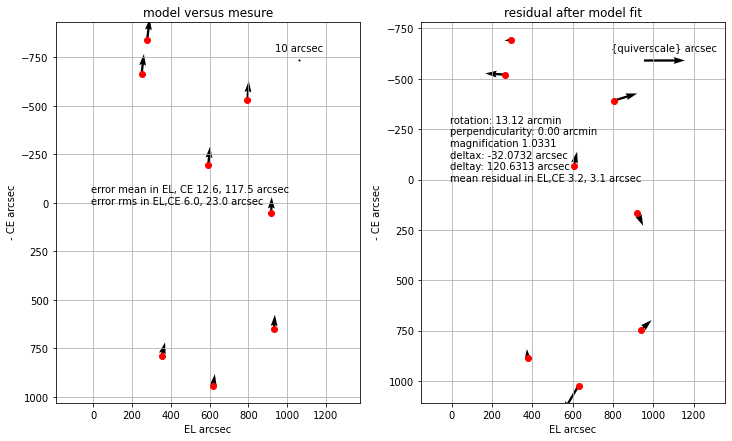

After updating:
    mask_rotation: 13.120608368474695 arcmin
    FOV center in guider: 1344.9458659102224 x 387.1221290050064 pix = 645.3214467959683 arcsec x -142.6261019631289 arcsec arcsec
    mask_magnification correction: 1.0330544879844736  
    


In [13]:
slits_coord_obs_det = np.array([
[ 1346.5,	435.5  ],
[ 1842.4207,1214.4992  ],
[ 1414.5  ,	1875.5  ],
# [ ? ,   	?  ],
[ 1747.5 ,	707.5  ],
[ 1619.5 ,	2000.5  ],
[ 1321.5 ,	593.5  ],
[ 1862.1 ,	1746.9  ],
[ 1589.5,	1002.5  ]]) 

slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
weight = np.array( [1.]*16  + [1./(1. + 1e-1)]*16)
G2UVcor, residuals = G2UV.update_model((slit_coords[:3] + slit_coords[4:])[:8], slits_coord_obs[:], plot=True, figsize=(12,7))#, labels=slits_valid


Fitting rotation, translation and magnification
gamma: 0.9911138765520151
theta: -6.184053343804603 arcmin
dx: 8.58433642718091 arcsec
dy: -2.9971661213587364 arcsec
variances: [4.98286342e-04 1.71298226e+00 4.33639690e-01 4.33639690e-01]

residuals in arcsec: [[-2.57702142 -3.46562441]
 [-2.77141572  1.42017551]
 [ 4.16058768  2.89082677]
 [ 2.00960103  3.69804689]
 [ 2.34341318 -1.01347078]
 [ 0.34350637  1.06100336]
 [ 2.73203369 -0.96419969]
 [-6.37638987 -4.37055912]
 [ 0.13568505  0.74380146]]
max residual in EL,CE 6.4, 4.4 arcsec
mean residual in EL,CE 3.2, 2.6 arcsec


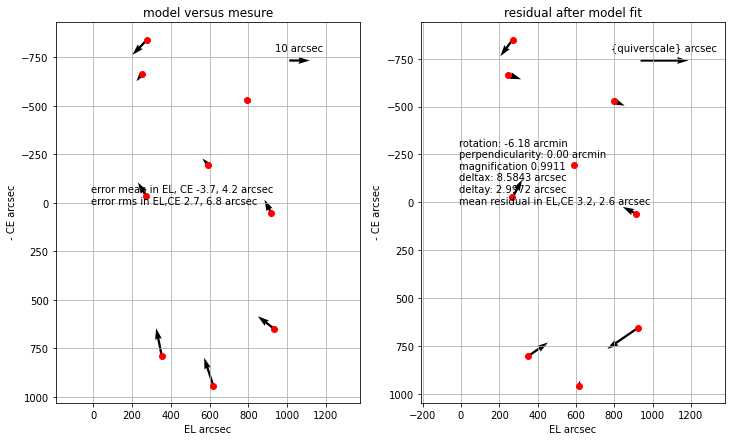

After updating:
    mask_rotation: -6.184053343804603 arcmin
    FOV center in guider: 1359.3382789815819 x 511.278864338963 pix = 658.3481796933073 arcsec x -27.67915041561571 arcsec arcsec
    mask_magnification correction: 0.9911138765520151  
    


(<guider2UV.guider2UV.Guider2UV at 0x7fc868ffa430>,
 array([[-7.15839284e-04, -9.62673447e-04],
        [-7.69837700e-04,  3.94493197e-04],
        [ 1.15571880e-03,  8.03007437e-04],
        [ 5.58222509e-04,  1.02723525e-03],
        [ 6.50948106e-04, -2.81519660e-04],
        [ 9.54184355e-05,  2.94723155e-04],
        [ 7.58898248e-04, -2.67833246e-04],
        [-1.77121941e-03, -1.21404420e-03],
        [ 3.76902925e-05,  2.06611516e-04]]))

In [15]:
slits_coord_obs_det_new = np.array([
[ 1328  ,   295.5   ],
[ 1835.6,	1117.9  ],
[ 1392.5,	1800.5  ],
[ 1322.5,	1044.5  ],
[ 1742.5,	582.5   ],
[ 1605.5,	1939.5  ],
[ 1307.8,	461.5   ],
[ 1850.5,	1663    ],
[ 1577.5,	888.5   ]]) 
# ss = G2UV.detector2guider(slits_coord_obs_det_new, wave=obs_wave, angle=True  )
# [[s.lon.deg[0], s.lat.deg[0]]  for s in ss]
G2UV.update_model(slit_coords[:9], G2UV.detector2guider(slits_coord_obs_det_new, wave=obs_wave, angle=True  ),plot=True, figsize=(12,7))


### check updating without fitting magnification

In [53]:
G2UVtest=G2UV.copy()
G2UVtest.FieldP.radial_mag_polynomial = (42.26134, 0., 0.)
G2UVtest.FieldP.radial_mag_inv_polynomial = (1./42.26134, 0., 0.)
G2UVtest.FieldP.gamma = 1.
print(G2UVtest)


Guider2UV object:
    Local Field Projector: 
ScienceMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=-90.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (352.3424, 0.21245)>)>
    gamma: 1.0

    Guider Field Projector: 
GuiderMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.42402654, 36.43499699)>)>
    wcs: WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 250.424026537  36.4349969891  
CRPIX : 640.0  540.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.00024648264068189  0.00024664057706659  
NAXIS : 0  0

    mask_rotation: 0.0 arcmin
    FOV center in guider: 1356.4845946522387x515.5439768745559 pix



Fitting rotation, translation and magnification
gamma: 2.061584734457727
theta: -526.8869846631383 arcmin
dx: -645.3679456401396 arcsec
dy: -61.49964775198307 arcsec
variances: [5.01636113e-04 1.72449793e+00 4.49597480e-01 4.49597480e-01]

residuals in arcsec: [[-461.77428381 -850.82932275]
 [ 339.99924913  -33.57990358]
 [-126.5456638   818.33030724]
 [ 170.60406696 -496.92254181]
 [ -47.75120638  807.11881761]
 [-197.80658178 -619.15019959]
 [ 206.32379513  607.01933994]
 [ 116.95062455 -231.98649706]]
max residual in EL,CE 461.8, 850.8 arcsec
mean residual in EL,CE 242.8, 622.4 arcsec


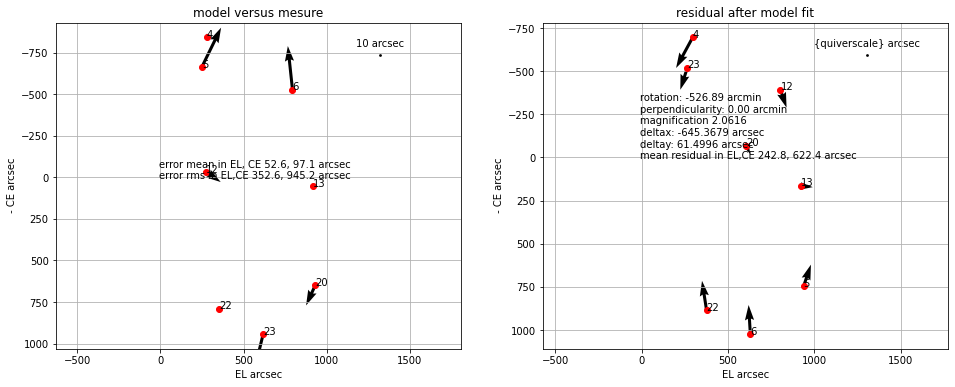

After updating:
    mask_rotation: -526.8869846631383 arcmin
    FOV center in guider: 1405.3930812728152 x 314.4592444464706 pix = 702.6396487087574 arcsec x -210.87229823495593 arcsec arcsec
    mask_magnification correction: 2.061584734457727  
    


In [54]:
G2UVcor_test, residuals = G2UVtest.update_model(slits_coord_valid, slits_coord_obs, labels=slits, plot=True, figsize=(16,6), gamma=True)


### save corrected model for future use (eg redo the calib on same field)

In [14]:
G2UVcor.save(filename="Calibration/Mappings/2022/XY/F3_XY_220717.pkl")

Dumping to Calibration/Mappings/2022/XY/F3_XY_220717.pkl


## 13 - Rotate carousel to science mask
## 14 - Note open-mask guider ref point
## 15 - Check corrected model through science mask

In [15]:
moves, flags, slit_coords = G2UVcor.compute_autocoll_moves_slits(slits, F1, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
moves = Table.from_pandas(pd.DataFrame(np.hstack((moves,flags[:,None])), columns=["EL","CE","UV_image"]))
print("(They have been copied to clipboard, paste it in the spreadsheet)")
moves.to_pandas().to_clipboard()
moves

# new_cat = slit_path[:9]
new_cat["EL"] = moves["EL"][1:]
new_cat["CE"] = moves["CE"][1:]

new_cat["El_sky"] = new_cat["EL"]  * 2 * Elg 
new_cat["Cel_sky"] = new_cat["CE"] * 2 * CEg 
new_cat["Frame_angular_distance"] = np.sqrt(new_cat["El_sky"]**2 + new_cat["Cel_sky"]**2)
new_cat["frame_divided_sky"] = new_cat["Frame_angular_distance"] / new_cat["angular_distance"]
new_cat["EL_dec_ratio"] =   new_cat["El_sky"] / new_cat["dec_diff"]
new_cat["CE_ra_ratio"] =   new_cat["Cel_sky"] / new_cat["ra_diff"]
# new_cat
# new_cat.to_pandas().to_clipboard()

plt.figure()
plt.plot(new_cat["angular_distance"],-new_cat["EL_dec_ratio"],"P",label="El move / dec angular distance between targets")
plt.plot(new_cat["angular_distance"],-new_cat["CE_ra_ratio"],"X",label="CE move / ra angular distance between targets")
plt.plot(new_cat["angular_distance"],new_cat["frame_divided_sky"],"o",label="Sky angular move / angular distance between targets")
plt.legend()
plt.show()
new_cat#["ra_diff","dec_diff","El_sky","Cel_sky","frame_divided_sky","EL_dec_ratio","CE_ra_ratio"]#,"EL_moves","CE_moves"


slit position in mm on mask: [ 9.60644814 -4.4384782 ]
slit position in mm on mask: [-0.90105352  3.07247507]
slit position in mm on mask: [-9.55164963 -3.55546162]
slit position in mm on mask: [ 0.10439566 -4.49041265]
slit position in mm on mask: [5.92437194 1.6321297 ]
slit position in mm on mask: [-11.34158824  -0.43809484]
slit position in mm on mask: [ 7.50255328 -4.77857585]
slit position in mm on mask: [-7.90192726  3.23927113]
slit position in mm on mask: [ 2.02242367 -0.73669396]

targets local coords in siderostat local frame:
EL: 127.5 arcsec ; CE: 486.4 arcsec
EL: 453.6 arcsec ; CE: 30.6 arcsec
EL: 162.9 arcsec ; CE: -342.6 arcsec
EL: 123.9 arcsec ; CE: 75.3 arcsec
EL: 392.0 arcsec ; CE: 325.8 arcsec
EL: 298.8 arcsec ; CE: -420.7 arcsec
EL: 112.4 arcsec ; CE: 395.2 arcsec
EL: 459.9 arcsec ; CE: -272.2 arcsec
EL: 288.0 arcsec ; CE: 157.5 arcsec

siderostat moves sequence: 
(They have been copied to clipboard, paste it in the spreadsheet)


NameError: name 'new_cat' is not defined

The moves has been copied. Add it to the [moves tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

Here we just wanted to do another try to verify that the least square gives consistent results

Fitting rotation, translation and magnification
gamma: 0.9907190063552016
theta: 5.199286407697351 arcmin
dx: 6.47584039462077 arcsec
dy: 0.20600990158452986 arcsec
variances: [6.29416330e-04 2.16377395e+00 5.21677896e-01 5.21677896e-01]

residuals in arcsec: [[ 2.14345731 -0.63718189]
 [-1.4729248   4.3142004 ]
 [-0.28627211 -3.76349203]
 [ 1.48003037  3.30289086]
 [-3.9158646   3.74503777]
 [ 2.05157384 -6.9614551 ]]
max residual in EL,CE 3.9, 7.0 arcsec
mean residual in EL,CE 2.2, 4.2 arcsec


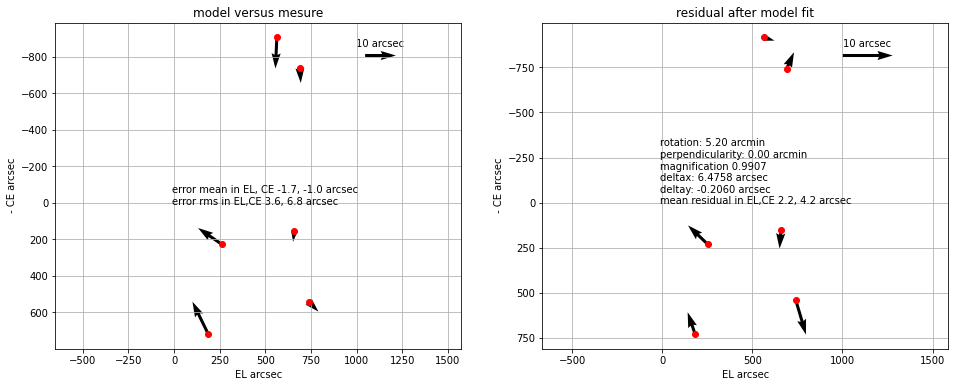

After updating:
    mask_rotation: 3.9069802872328943 arcmin
    FOV center in guider: 1399.2648803572893 x 368.49732464566944 pix = 691.7073759757741 arcsec x -159.94143168270693 arcsec arcsec
    mask_magnification correction: 1.0141468872165147  
    


(<guider2UV.guider2UV.Guider2UV at 0x7f842b04b100>,
 array([[ 5.95404808e-04, -1.76994970e-04],
        [-4.09145779e-04,  1.19838900e-03],
        [-7.95200316e-05, -1.04541445e-03],
        [ 4.11119548e-04,  9.17469683e-04],
        [-1.08774017e-03,  1.04028827e-03],
        [ 5.69881621e-04, -1.93373753e-03]]))

In [114]:
slits_coord_obs_det = np.array([
[2015.5591,  	931.45115  ],
[1958.5063  ,	467.6615  ],
[1665.4307  ,	1955.4355  ],
[2034.4282 ,	1432.4388  ],
[2057.2718 ,	620.85921  ],
[1715.4736 ,	1503.1555  ],
[2102.354,  	1784.8877  ]]) 

slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
weight = np.array( [1.]*16  + [1./(1. + 1e-1)]*16)
G2UVcor.update_model(slits_coord_valid[1:], slits_coord_obs[1:], plot=True, figsize=(16,6))#, labels=slits_valid





## 16 - Note science-mask guider ref point
## 17 - Go through the Star sequence 
 [29, 34, 18, 14]
we did not have the time to do this because G2UV was not well

In [33]:
G2UV.FieldP.center

<SkyCoord (ICRS): (ra, dec) in deg
    (352.3424, 0.21245)>

In [34]:
F1_stars

,Internal count,RA,DEC,X,Y,GAIA gband,SDSS gband,SDSS rband,Xguider,Yguider,Xguider2,Yguider2
0,1,352.192850,0.252679,-6.363780,1.711911,<NA>,<NA>,14,1523.021870,1092.005991,1510.598106,1094.353442
1,2,352.200065,-0.145873,-6.056907,-15.248016,<NA>,14,13,-92.453150,1117.879583,-106.559136,1098.822809
2,3,352.222365,-0.065909,-5.107941,-11.845152,<NA>,<NA>,14,249.573990,1011.842919,237.156463,997.317107
3,4,352.226278,0.227854,-4.941321,0.655490,<NA>,14,14,1426.059408,965.311039,1415.161923,966.312896
4,5,352.228576,-0.041124,-4.843635,-10.790471,9,10,9,353.410186,982.968197,341.453694,969.815458
5,6,352.228614,0.070363,-4.841979,-6.046274,<NA>,<NA>,9,809.952439,970.450789,798.488437,963.386666
6,7,352.249592,-0.047167,-3.949319,-11.047629,<NA>,<NA>,4,327.454205,896.769866,316.647234,883.187200
7,8,352.259168,0.072239,-3.541785,-5.966414,<NA>,<NA>,14,816.057777,847.628790,806.215203,840.552511
8,9,352.267202,0.107397,-3.199912,-4.470323,<NA>,13,12,955.786184,813.226581,946.488171,807.978677
9,10,352.315435,0.070363,-1.147428,-6.046280,<NA>,<NA>,14,806.981129,621.858786,800.097720,614.540002


In [16]:
# G2UVcor.FieldP.center = 36.9049, 0.65245
star_target_path = "Calibration/Targets/2022/GuidingStars/F3_guidingstars.fits"
# il faut que le centre soit bien defini à l'arcseconde pres.
# G2UVcor.FieldP = LocalScienceMaskProjector(center=coordinates.SkyCoord(36.9049*u.deg, 0.65245*u.deg), rotation=0.0*u.arcmin, gamma=1)


F1_stars = Table.read(star_target_path, format='fits').to_pandas()

stars = [20, 5, 9]#[29, 34, 18, 14]
selected_stars = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1_stars[F1_stars['Internal count'] == i],stars))))
# G2UVcor.FOV_center_guider_coord = 0.18182478, 0.00998363
star_moves, flags, stars_coord = G2UVcor.compute_autocoll_move_stars(stars, F1_stars, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
star_moves = pd.DataFrame(np.hstack((star_moves,flags[:,None])), columns=["EL","CE","Image"])
star_moves
star_moves.to_clipboard()
# stars_path = vstack((selected_stars,selected_stars[::-1]) )
# selected_stars['lon'] = [s.lon.deg*3600 for s in stars_coord]
# selected_stars['lat'] =  [s.lat.deg*3600 for s in stars_coord]
# print("(They have been copied to clipboard, paste it in the spreadsheet)")
# star_moves.to_clipboard()
# star_moves




targets local coords in siderostat local frame:
EL: -257.3 arcsec ; CE: 152.4 arcsec
EL: -133.4 arcsec ; CE: -129.4 arcsec
EL: 131.9 arcsec ; CE: -62.2 arcsec

siderostat moves sequence: 


The moves has been copied. Add it to the [moves tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

In [27]:
selection = selected_stars['Internal count',
 'RA',
 'DEC',
 'X',
 'Y',
 'GAIA gband',
 'SDSS gband',
 'SDSS rband',
 'Xguider',
 'Yguider']
# selection=vstack((selection,selection[::-1]))
selection.add_row(["-99",-99,-99,640,540,-99,-99,-99,-99,-99])
selection.to_pandas().to_clipboard()
selection

Internal count,RA,DEC,X,Y,GAIA gband,SDSS gband,SDSS rband,Xguider,Yguider
int64,float64,float64,float64,float64,int64,object,object,float64,float64
20,352.387774,-0.111235,1.930845,-13.773961,--,12,12,58.50638377206623,322.426324860575
5,352.228576,-0.041124,-4.843635,-10.790471,9,10,9,353.4101855036889,982.9681967990201
9,352.267202,0.107397,-3.199912,-4.470323,--,13,12,955.7861839419787,813.2265808353644
-99,-99.0,-99.0,640.0,540.0,-99,-99,-99,-99.0,-99.0


The stars table has been copied. Add it to the [stars tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)


## 18 - Through focus guide star 1
## 19 - Track mask to guider changes
------------------------------------------------------